In [ ]:
!pip install geopandas
!pip install geojson
!pip install rasterio
!pip install rasterstats

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 14.9 MB/s 
     |████████████████████████████████| 6.3 MB 58.4 MB/s 
     |████████████████████████████████| 16.7 MB 55.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.3 MB 1.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 130 kB 13.6 MB/s 


In [ ]:
from os import path as op
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import csv

import pickle
import rasterio
from sklearn.model_selection import train_test_split
from collections import OrderedDict
import itertools
from scipy import ndimage
from torch.utils.data import DataLoader
from torchvision import datasets,transforms,models
import torch.nn.functional as F 
from torch import cuda

import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix 

In [ ]:
 %load_ext autoreload
%autoreload 2

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import os
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.chdir('/content/drive/MyDrive/Space_Intelligence/Project_Scotland/Scotland_Segmentation_Sparse_Labels/data')

In [ ]:
import sys
import sys
sys.path.insert(0,'/content/drive/MyDrive/Space_Intelligence/Project_Scotland/Scotland_Segmentation_Sparse_Labels/src')

In [ ]:
import CNN_Train_Validate 


In [ ]:
X = np.load('X.npy')

In [ ]:
X[0].shape

(13, 256, 256)

In [ ]:
X[0][0]

array([[0.1233 , 0.11295, 0.12025, ..., 0.11025, 0.10965, 0.11195],
       [0.12655, 0.1224 , 0.1206 , ..., 0.11355, 0.1133 , 0.1103 ],
       [0.1247 , 0.1214 , 0.1227 , ..., 0.11945, 0.1137 , 0.10495],
       ...,
       [0.1069 , 0.10555, 0.1065 , ..., 0.10055, 0.09465, 0.0905 ],
       [0.1085 , 0.10405, 0.10155, ..., 0.10955, 0.1055 , 0.0993 ],
       [0.1068 , 0.0977 , 0.101  , ..., 0.1029 , 0.1012 , 0.10025]],
      dtype=float32)

In [ ]:
y = np.load('y.npy')

In [ ]:
y[0].shape

(1, 256, 256)

In [ ]:
classes = ['Agriculture', 'Bares_and_Built', 'Bogs', 'Forest', 'Grassland','Shrub/Heathland','Water']
labels=[0,1,2,3,4,5,6]

In [ ]:
train_data,test_data = CNN_Train_Validate.create_train_test_split(X,y,test_size=0.3,random_state=42,gpu=True)


In [ ]:
# Here we make augmentations
# First we need to make the size of the samples for each class to be approximately equal
# take classes 2,5,6 -> Bogs, Shrub/Heathland, because these 2 classes confuse each other
# and also they are the only classes that we have poor performance on
klas_2 = CNN_Train_Validate.select_class(train_data,2)
klas_5 = CNN_Train_Validate.select_class(train_data,5)

klas_2_augm = CNN_Train_Validate.augment_dataset(klas_2,2)
klas_5_augm = CNN_Train_Validate.augment_dataset(klas_5,2)

In [ ]:
# add the augmented datasets to our train set
train_data+=klas_2_augm+klas_5_augm

In [ ]:
# create a test model
model = CNN_Train_Validate.UNet(in_channels=13,out_channels=7,init_features=32).cuda()

In [ ]:
def test_statistics(test_true,test_predictions,verbose=True):

    '''
    This functions calculates accuracy,balanced_accuracy,f1,recall, and precision.
    input: test_true - the real predicted test values taken from the whole test dataloader,
           test_predictions - predicted values on the whole test dataloader.
    output: results for the statistics
    '''
     
    # the number of samples in our test loader
    n_test = len(list(test_true))

    # calculate the statistics
    bal_acc = balanced_accuracy_score(test_true,test_predictions)
    
    recall = recall_score(test_true,test_predictions,average='weighted')

    precision = precision_score(test_true,test_predictions,average='weighted')

    f1 = f1_score(test_true,test_predictions,average='weighted')
    
    accuracy = accuracy_score(test_true,test_predictions)


    
    if verbose==True:

        print(f'Accuracy:{accuracy}')
        print(f'Balanced Accuracy:{bal_acc}')
        print(f'Recall:{recall}')
        print(f'Precision:{precision}')
        print(f'f1 score:{f1}')


    return bal_acc,recall,precision,f1,accuracy

In [ ]:
def mask_trainings_and_predictions_equal_polygons(x_train,y_train,model):

 '''
   Input: batch from our training dataset and our model.
   Output: modified y_train and modified predictions.
   
   Description: We work with sparse labels so most of the pixels in the elements of y_batch
                will be nodata (less than 0 ). We don't want our loss to take them into account,
                so we need to create a mask which restricts the domain of the loss function
                only on the non-negative pixel values of the elements from y_batch. In this fun-
                ction we also consider each polygon to be equally important, no matter how small
                it is.

  '''
# record the batch size
 batch_size = y_train.shape[0]

  # we find the predictions
 y_pred  = model(x_train)

 # copy(clone) y_train
 y_train_copy = y_train.clone()

# we create the desired mask and apply it to y_train
 mask_train = (y_train >= 0)
 y_train_masked = y_train[mask_train]

 # we reshape it by removing a band ( band 1 )
 y_train_copy = y_train_copy.reshape(batch_size,256,256)

 # we merge the labels from each batch to one long image
 y_train_copy = y_train_copy.reshape(256*batch_size,256).T

 # -999 -> 0, -1->0, 0->500. 
 mask_999 = (y_train_copy==-999)
 mask_0 = (y_train_copy==0)
 mask_1 = (y_train_copy==-1)

 y_train_copy[mask_999]=0
 y_train_copy[mask_1]=0
 y_train_copy[mask_0]=500

 # we will need this structure for the following function
 s = ndimage.generate_binary_structure(2,2)

 # this is our polygons id mask
 
 polygons_id_mask = ndimage.label(y_train_copy.cpu(),structure=s)[0]
 polygons_id_mask = torch.LongTensor(polygons_id_mask.T)
 polygons_id_mask = polygons_id_mask.view(batch_size,1,256,256)

 # we use the mask_train to take only the non nan valus
 polygons_id_mask_masked = polygons_id_mask[mask_train]

 # we reshape our mask ( remove 1 dimension )
 mask_train = mask_train.reshape([len(x_train),256,256])

# this is our masked y_pred
 y_pred = torch.cat([y_pred[:,0,:,:][mask_train],  y_pred[:,1,:,:][mask_train],y_pred[:,2,:,:][mask_train],y_pred[:,3,:,:][mask_train],
           y_pred[:,4,:,:][mask_train],y_pred[:,5,:,:][mask_train], y_pred[:,6,:,:][mask_train]],dim=0)
  
                      
  # we fix y_pred to the appropriate shape
 y_pred = torch.transpose(y_pred.view(7,-1),0,1)

 # we take the indexes of the sorted polygons_id_mask_masked
 sorted_indexes_polygons_id_mask_masked = polygons_id_mask_masked.argsort()

 # we sort y_train, y_pred, and polygons_id_mask_masked based on the above indexes
 y_train_masked_sorted = y_train_masked[sorted_indexes_polygons_id_mask_masked]
 sorted_polygons_id_mask_masked = polygons_id_mask_masked[sorted_indexes_polygons_id_mask_masked]
 y_pred_masked_sorted = y_pred[sorted_indexes_polygons_id_mask_masked]


 # now we divide our y_train and y_pred into subsets for every polygon
 y_train_masked_split_by_polygons = np.split(y_train_masked_sorted, np.unique(sorted_polygons_id_mask_masked, return_index=True)[1][1:])
 y_pred_masked_split_by_polygons = np.split(y_pred_masked_sorted, np.unique(sorted_polygons_id_mask_masked, return_index=True)[1][1:])

 return y_train_masked_split_by_polygons,y_pred_masked_split_by_polygons

In [ ]:
def calculate_loss(y_train_masked_split_by_polygons,y_pred_masked_split_by_polygons,percentage=0):

    '''
    This function takes two input arguments: y_train_masked_split_by_polygons and
    y_pred_masked_split_by_polygons, which denote our y_train labels per pixel but
    grouped also per polygon. That is how we give equal importance to each polygon
    when training. We want to explore how sparse we can go se we set percentage to reduce.
    Output cross_entropy_loss as average of the losses for the number of polygons
    '''
    number_of_polygons = len(y_pred_masked_split_by_polygons)
    acc_loss = 0 # the accumulated loss based on the polygons
    criterion = nn.CrossEntropyLoss()
    for y_t,y_p in zip(y_train_masked_split_by_polygons,y_pred_masked_split_by_polygons):
        
        # total number of pixels in the polygon
        n = len(y_t)

        # taking 1-percentage number of pixels from the upper number
        n_choice = int(n*(1-percentage))
        
        # make a check
        if n_choice == 0:
          n_choice = 1

        #print(f'n:{n}')
        #print(f'n_choice:{n_choice}')
        indexes = np.random.choice(n,n_choice,replace=False)
        y_p = y_p[indexes]
        y_t = y_t[indexes]
        acc_loss+=criterion(y_p,y_t)
        
    return acc_loss/number_of_polygons

In [ ]:
#np.random.seed(43)
#calculate_loss(a,b,percentage=0.6)

In [ ]:
def cross_validate_dl_model(labels,classes,init_features,epochs,batch_size,init_lr,X,y,folds=3,seed=False,augment=True,percentage=0):

    '''
    This function takes a deep learnin model, as well ass X and y data. It initiates
    a cross validated training of the model and outputs an average balanced accuracy,
    precision, recall, f1, and confusion matrix with respect to the different folds.
    '''

    results_bal_acc = []
    results_prec=[]
    results_recall=[]
    results_f1=[]
    results_cm = []
    results_acc=[]

    # Our split
    if seed!=False:  
      np.random.seed(seed)

    kf = KFold(n_splits=folds,shuffle=True)
    kf.get_n_splits(X)


    for train_index, test_index in kf.split(X): # loop through the indices of the different folds

        # Create the X_train,X_test,y_train,y_test split
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        
        if len(np.unique(y_train))!=len(np.unique(y_test)):
          print('ERROR')
          return 'ERROR'
        
        # Put them to gpu
        X_train = torch.FloatTensor(X_train).cuda()
        y_train = torch.LongTensor(y_train).cuda()

        X_test = torch.FloatTensor(X_test).cuda()
        y_test = torch.LongTensor(y_test).cuda()

        # Prepare the training set for batch sampling
        train_data = list(zip(X_train,y_train))

        # Prepare the testing set for batch sampling
        test_data = list(zip(X_test,y_test))

        ## augment our training data
        if augment == True:
            # Here we make augmentations
            # First we need to make the size of the samples for each class to be approximately equal
            # take classes 2,5,6 -> Bogs, Shrub/Heathland, because these 2 classes confuse each other
            # and also they are the only classes that we have poor performance on
            klas_2 = CNN_Train_Validate.select_class(train_data,2)
            klas_5 = CNN_Train_Validate.select_class(train_data,5)

            torch.use_deterministic_algorithms(False)
            klas_2_augm = CNN_Train_Validate.augment_dataset(klas_2,2)
            klas_5_augm = CNN_Train_Validate.augment_dataset(klas_5,2)

            # add the augmented datasets to our train set
            train_data+=klas_2_augm+klas_5_augm

        # we train our. model
        model,test_true,test_predictions,cm = train_validate_model(train_data=train_data, test_data=test_data, labels=labels, classes=classes, 
                                                 init_features=init_features, epochs = epochs, batch_size=batch_size, init_lr=init_lr,percentage=percentage)
                                                
        # calculate the balanced accuracy 
        bal_acc,recall,precision,f1,acc = test_statistics(test_true,test_predictions,verbose=True)

        # append them to our lists
        results_bal_acc.append(bal_acc)
        results_prec.append(precision)
        results_recall.append(recall)
        results_f1.append(f1)
        results_cm.append(cm)
        results_acc.append(acc)
          

    return results_acc,results_bal_acc,results_prec,results_recall,results_f1,results_cm

In [ ]:
torch.cuda.empty_cache()

In [ ]:
def train_validate_model(train_data,test_data,labels,classes,input_model = False,init_features=32,batch_size=16,epochs=20,init_lr=0.001,verbose=False,gpu=True,percentage=0):
    
    '''
    Function that trains our neural network
    input: train and test data, labels=[0,1,2,3,...],classes=['Agriculture',..] 
           init_features, batch_size, number of epochs,
           and gpu = True/False - whether we use gpu or not
           init_lr - initial learning rate

    output: our trained model, all true classes from the whole test set, and all
            predicted classes from the test set
    '''
    np.random.seed(3407)
    torch.manual_seed(3407)
    torch.use_deterministic_algorithms(True)
    
    # trackers for printing
    train_losses=[]
    val_losses=[]
    Epochs = list(torch.arange(epochs))

    # we check for input model
    if input_model==False:  
      
      # instatiate our model
      if gpu == True:
          model = CNN_Train_Validate.UNet(in_channels=13,out_channels=7,init_features=init_features).cuda()
      else:
          model = CNN_Train_Validate.UNet(in_channels=13,out_channels=7,init_features=init_features)
    
    else:
      model = input_model

    # creating our train and test loaders
    train_loader = DataLoader(train_data,batch_size=batch_size,shuffle=True)
    test_loader = DataLoader(test_data,batch_size=45,shuffle=False)

    # setting our loss function and our optimizer
    criterion = nn.CrossEntropyLoss() 
    optimizer = torch.optim.Adam(model.parameters(),lr = init_lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer,20)

    for i in range(epochs):
        i+=1
        
        ########## TRAINING ########
        for batch,(x_train_batch,y_train_batch) in enumerate(train_loader):
            batch+=1

            # apply mask on our y_train_batch and y_pred_batch 
            y_train_masked_split_by_polygons,y_pred_masked_split_by_polygons = mask_trainings_and_predictions_equal_polygons(x_train_batch,y_train_batch,model)
        
            # calculate the loss for the current batch
            train_loss=calculate_loss(y_train_masked_split_by_polygons,y_pred_masked_split_by_polygons,percentage)
            
            optimizer.zero_grad() # optimizing
            train_loss.backward()       # back propagation
            optimizer.step()      # step update
        
        # update the scheduler
        scheduler.step()

        # update the train losses
        train_losses.append(train_loss)

        if verbose == True:
            print(f"Epoch:{i}, train_loss:{train_loss}, {optimizer.param_groups[0]['lr']}")

        ######## VALIDATION ######

        # if we are in the last epoch
        if i == epochs-1:
          
          test_predictions=[] # we will append here the predictions from 
                              # y_pred_batch from each test batch
                            
          test_true = [] # we will append here the y_test_batch from each
                         # test batch

        for batch,(x_test_batch,y_test_batch) in enumerate(test_loader):

            with torch.no_grad():
                 
                 # apply mask on our y_train_batch and y_pred_batch 
                y_test_batch,y_pred_batch = CNN_Train_Validate.mask_trainings_and_predictions(x_test_batch,y_test_batch,model)
            
            if i == epochs-1:
              # generate batch predictions from y_pred_batch
              batch_predictions = CNN_Train_Validate.nn_generate_predictions(y_pred_batch)
              test_predictions+=batch_predictions

              # append the results for 
              test_true+=list(y_test_batch.cpu().detach().numpy())
            
            # calculate the loss for the current batch
            val_loss=criterion(y_pred_batch,y_test_batch)  

        # Update the val losses
        val_losses.append(val_loss)

        # Adjust the learning rate based on the validation loss
        #scheduler.step(val_loss)
        
        if verbose == True:
            print(f"Epoch:{i}, val_loss:{val_loss}, {optimizer.param_groups[0]['lr']}")

    print(' ')
    print(f'init features: {init_features}, batch size: {batch_size}, learning rate: {init_lr}')

    ####################### PLOTTING #############################

    # plot a confusion matrix
    cm = confusion_matrix(test_true,test_predictions,labels=labels)
    CNN_Train_Validate.plot_cm(cm,classes)


    # Plot train and validation losses
    train_losses = [item.cpu().detach() for item in train_losses]
    val_losses = [item.cpu().detach() for item in val_losses]
    plt.title('TRAIN AND VALIDATION LOSSES')
    plt.plot(Epochs,train_losses,label='train_loss',color='blue')
    plt.plot(Epochs,val_losses,label='val_loss',color='red')
    plt.xlabel('Epochs')
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    return model,test_true,test_predictions,cm


 
init features: 32, batch size: 16, learning rate: 0.001


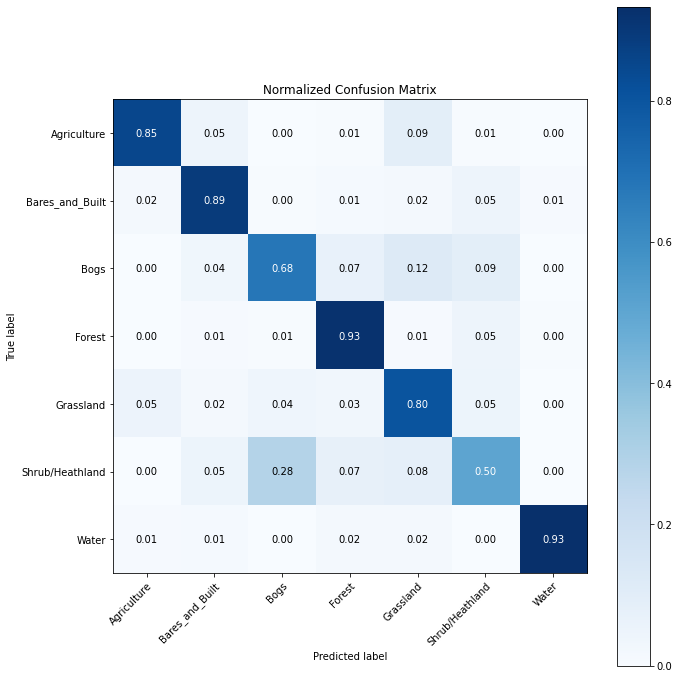

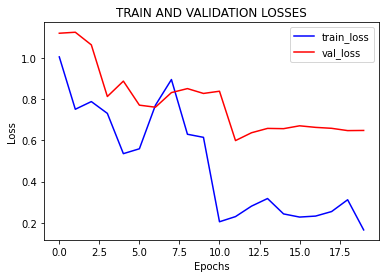

In [ ]:
model,test_true,test_predictions,cm  = train_validate_model(train_data,test_data,labels,classes,init_features=32,epochs=20,batch_size = 16,init_lr=1e-3,percentage=0);

In [ ]:
cuda.empty_cache()

In [ ]:
# cosine annealing warm restart
model,test_true,test_predictions,cm  = train_validate_model(train_data,test_data,labels,classes,init_features=100,epochs=38,batch_size = 4,init_lr=1e-3);

In [ ]:
CNN_Train_Validate.test_statistics(test_true,test_predictions,verbose=True);

In [ ]:
torch.save(model.state_dict(),'Best.net')

In [ ]:
# switching to manual training
model,test_true,test_predictions = train_validate_model(train_data,test_data,labels,classes,input_model = model,init_features=64,batch_size = 4,init_lr=1e-4,epochs=40);

In [ ]:
CNN_Train_Validate.test_statistics(test_true,test_predictions,verbose=True);

In [ ]:
# ball acc mean
np.array(results_acc).mean()


0.8011468614514964

In [ ]:
# ball acc std
np.array(results_acc).std()

0.020061768509547277

In [ ]:
bal_acc_std

[0.03087976402866641, 0.026704661731068394, 0.023045600245615493]

In [ ]:
bal_acc_mean

[0.7807720067695434, 0.789537819632035, 0.7830126876206962]

# Percentage 


 
init features: 32, batch size: 16, learning rate: 0.001


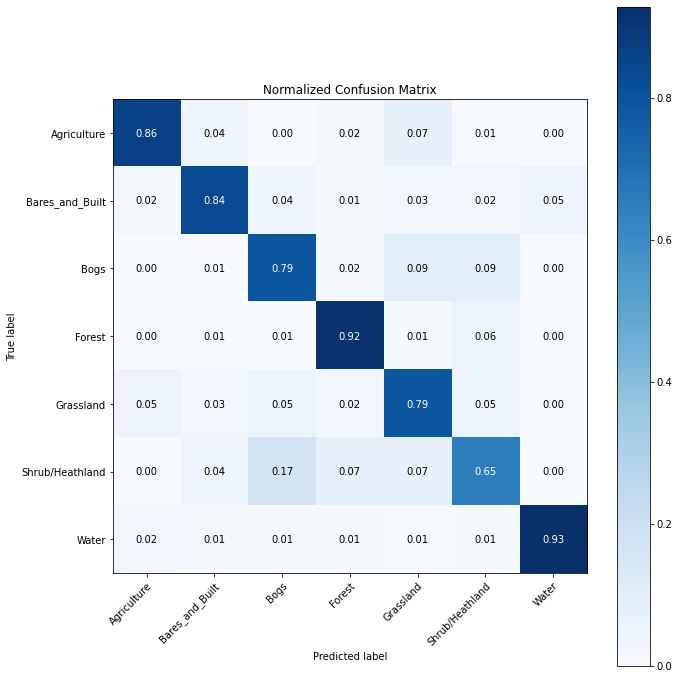

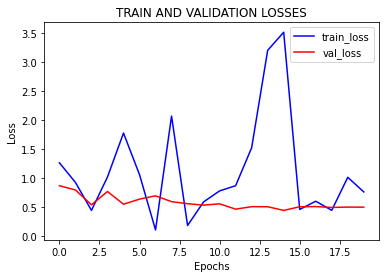

Accuracy:0.8475897575645505
Balanced Accuracy:0.825610982890386
Recall:0.8475897575645505
Precision:0.861560998083988
f1 score:0.8523201753409865
 
init features: 32, batch size: 16, learning rate: 0.001


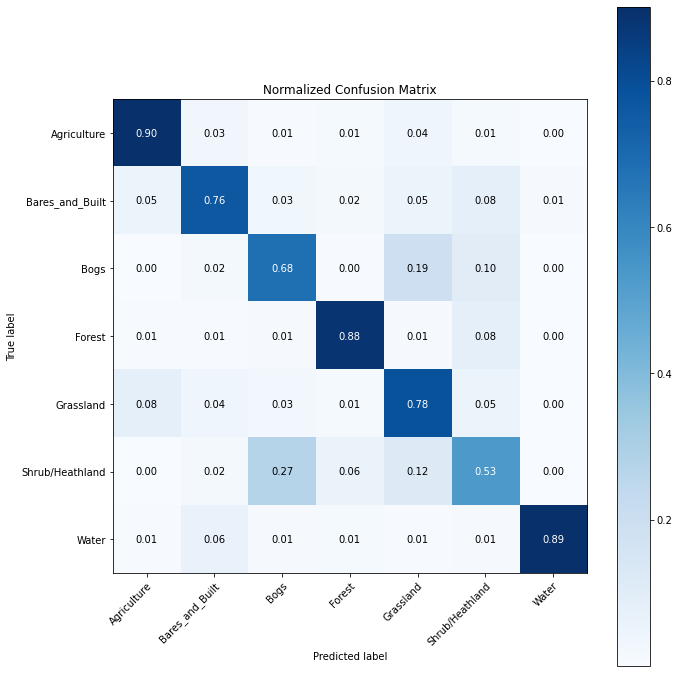

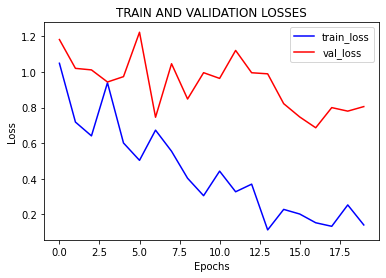

Accuracy:0.8158468007497847
Balanced Accuracy:0.7769864216456953
Recall:0.8158468007497847
Precision:0.8334626896571968
f1 score:0.8224997177809463
 
init features: 32, batch size: 16, learning rate: 0.001


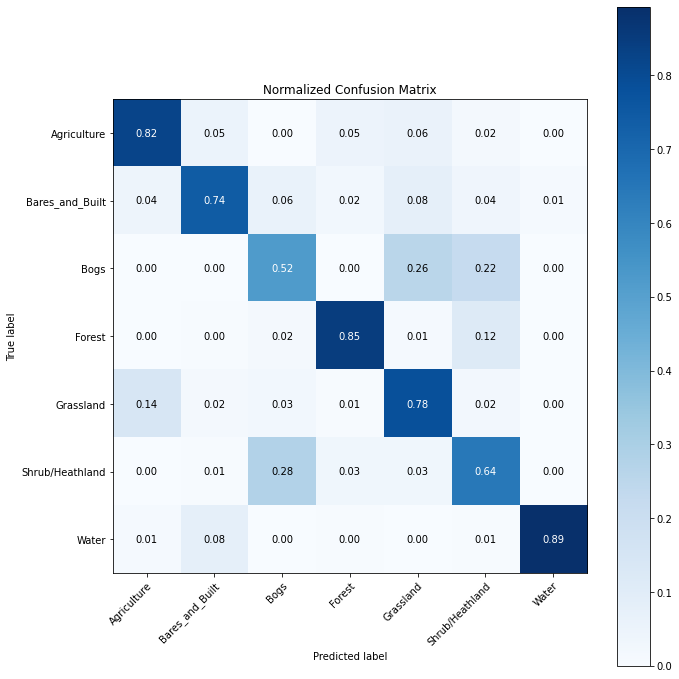

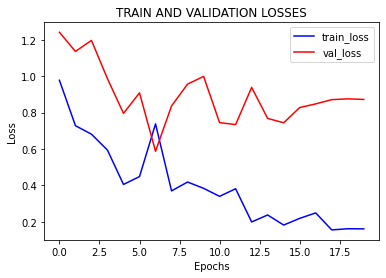

Accuracy:0.798136129139624
Balanced Accuracy:0.7503052895913375
Recall:0.798136129139624
Precision:0.8236709703876663
f1 score:0.8078925362945508
percentage:0.0
The mean balanced accuracy is:0.7843008980424729
The mean accuracy is:0.8205242291513196
The mean precision is:0.8395648860429503
The mean recall is:0.8205242291513196
The mean f1 score is:0.8275708098054945
 
The std balanced accuracy is:0.03117545011203372
The std accuracy is:0.02045847979748723
The std precision is:0.016059081548140362
The std recall is:0.02045847979748723
The std f1 score is:0.018488568694397283
 
init features: 32, batch size: 16, learning rate: 0.001


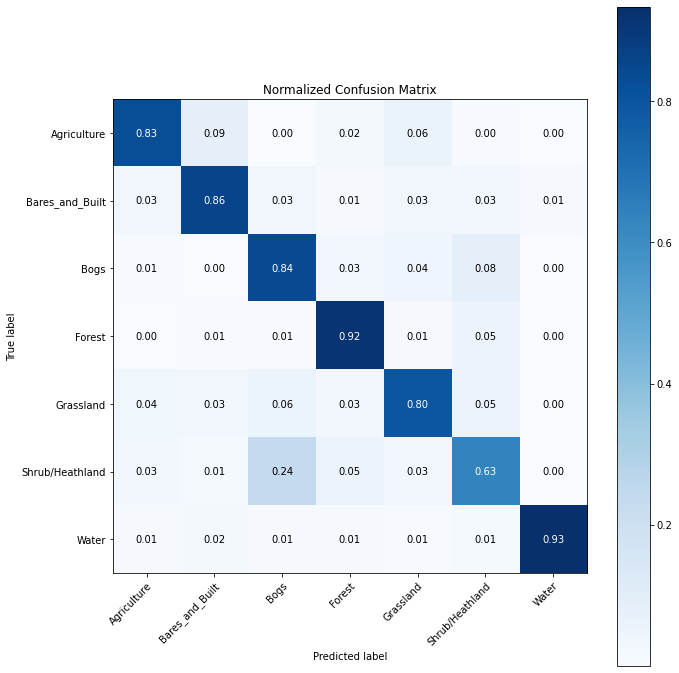

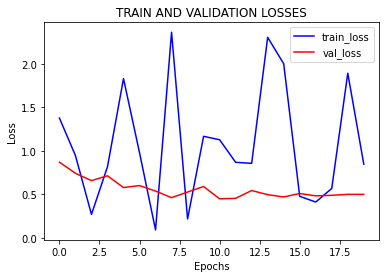

Accuracy:0.8415459031231447
Balanced Accuracy:0.8298039652199682
Recall:0.8415459031231447
Precision:0.864128889462213
f1 score:0.8484897911436641
 
init features: 32, batch size: 16, learning rate: 0.001


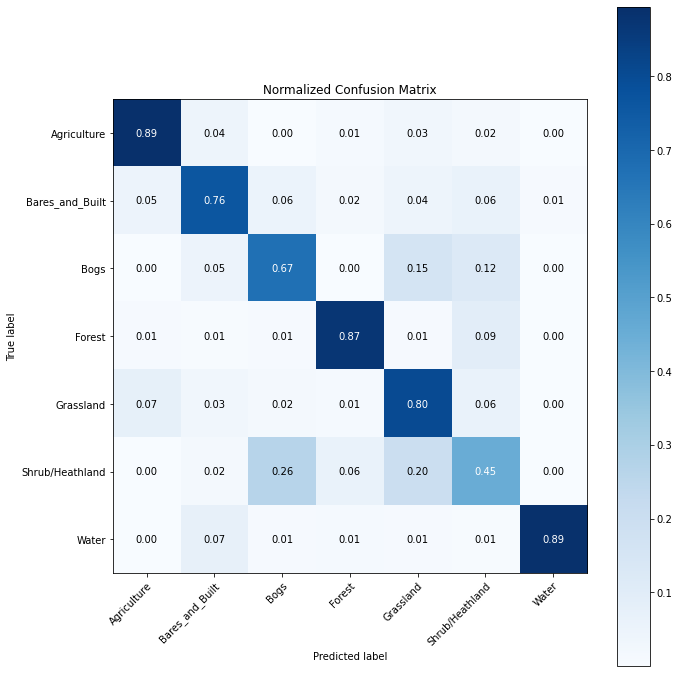

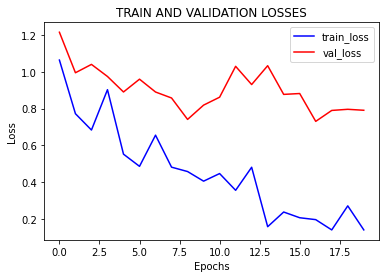

Accuracy:0.807913268149349
Balanced Accuracy:0.7634716027885123
Recall:0.807913268149349
Precision:0.8251246310527918
f1 score:0.8146548057314452
 
init features: 32, batch size: 16, learning rate: 0.001


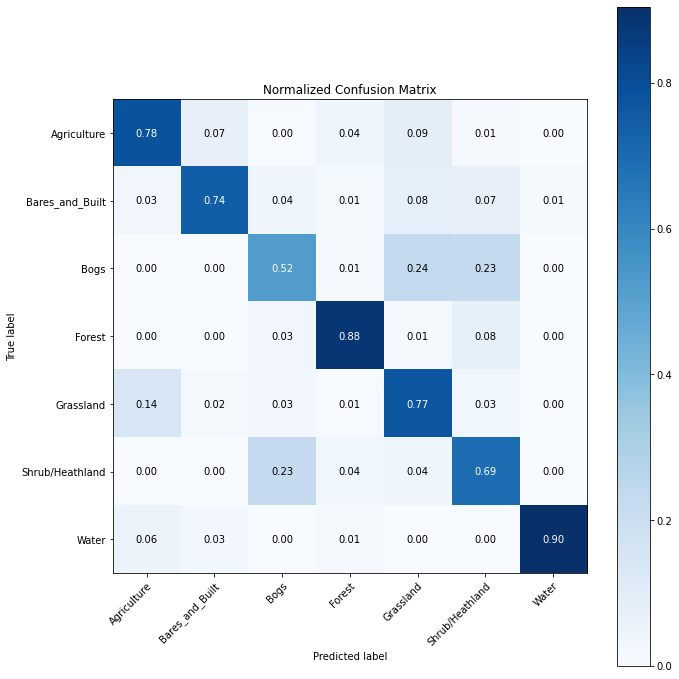

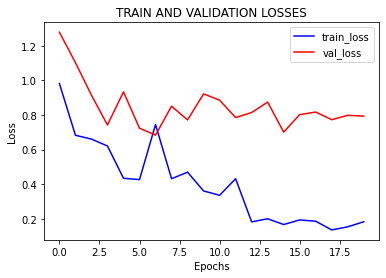

Accuracy:0.8006674199227475
Balanced Accuracy:0.7568285185627505
Recall:0.8006674199227475
Precision:0.8211270697692441
f1 score:0.8083682702399315
percentage:0.1
The mean balanced accuracy is:0.783368028857077
The mean accuracy is:0.8167088637317471
The mean precision is:0.8381792080688499
The mean recall is:0.8186165464415334
The mean f1 score is:0.8257042160885874
 
The std balanced accuracy is:0.032946975394123855
The std accuracy is:0.017809818891613583
The std precision is:0.019397792449403543
The std recall is:0.017809818891613583
The std f1 score is:0.017619633007780373
 
init features: 32, batch size: 16, learning rate: 0.001


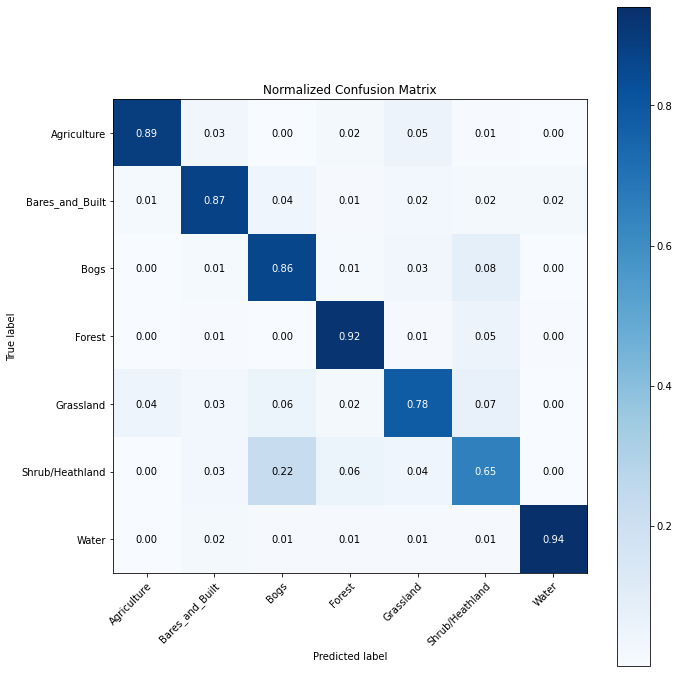

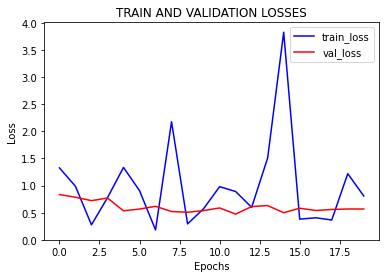

Accuracy:0.8595022822606546
Balanced Accuracy:0.8450853293019885
Recall:0.8595022822606546
Precision:0.8776639804967514
f1 score:0.8654299535946857
 
init features: 32, batch size: 16, learning rate: 0.001


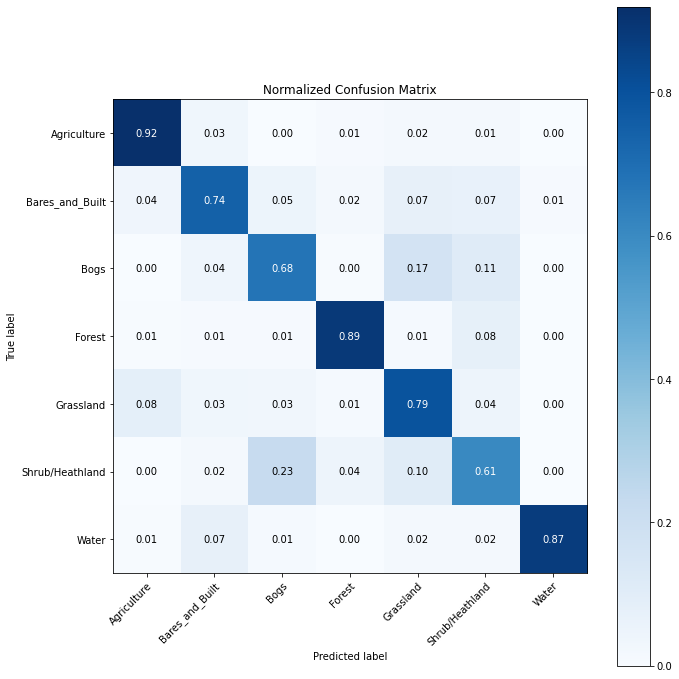

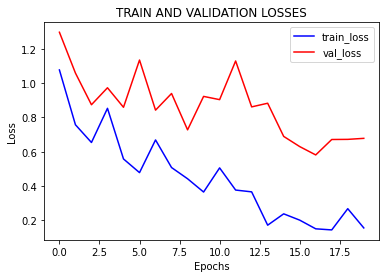

Accuracy:0.8252191093773747
Balanced Accuracy:0.7857436459366693
Recall:0.8252191093773747
Precision:0.8420718875625429
f1 score:0.8313779706172256
 
init features: 32, batch size: 16, learning rate: 0.001


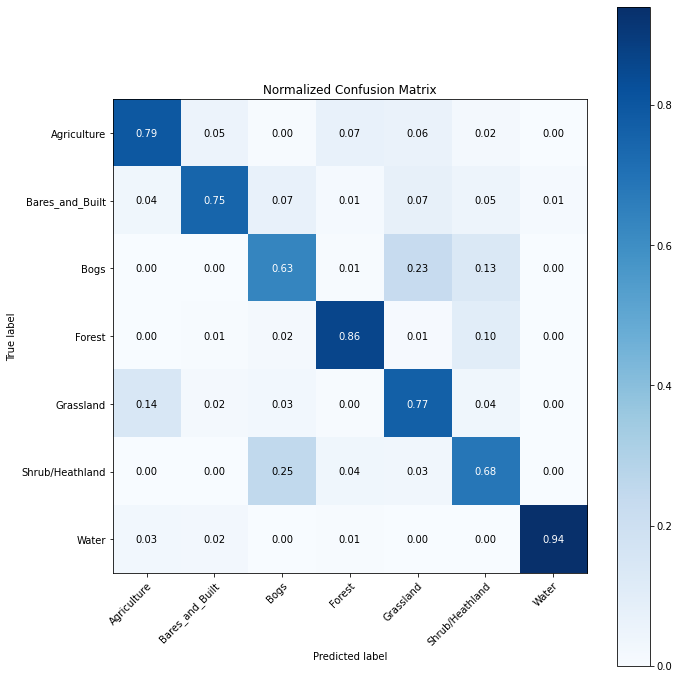

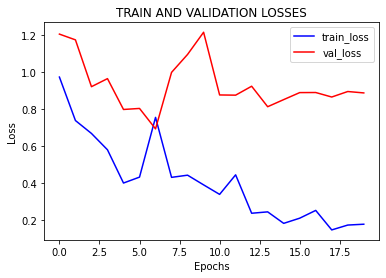

Accuracy:0.8053095794904135
Balanced Accuracy:0.774721188236587
Recall:0.8053095794904135
Precision:0.8274335661013619
f1 score:0.813449782748073
percentage:0.2
The mean balanced accuracy is:0.8018500544917483
The mean accuracy is:0.8300103237094808
The mean precision is:0.8418049647304172
The mean recall is:0.8224144721975158
The mean f1 score is:0.8293870003879453
 
The std balanced accuracy is:0.03090135255265561
The std accuracy is:0.02238197279758958
The std precision is:0.021092842559005037
The std recall is:0.02238197279758958
The std f1 score is:0.021558436415710005
 
init features: 32, batch size: 16, learning rate: 0.001


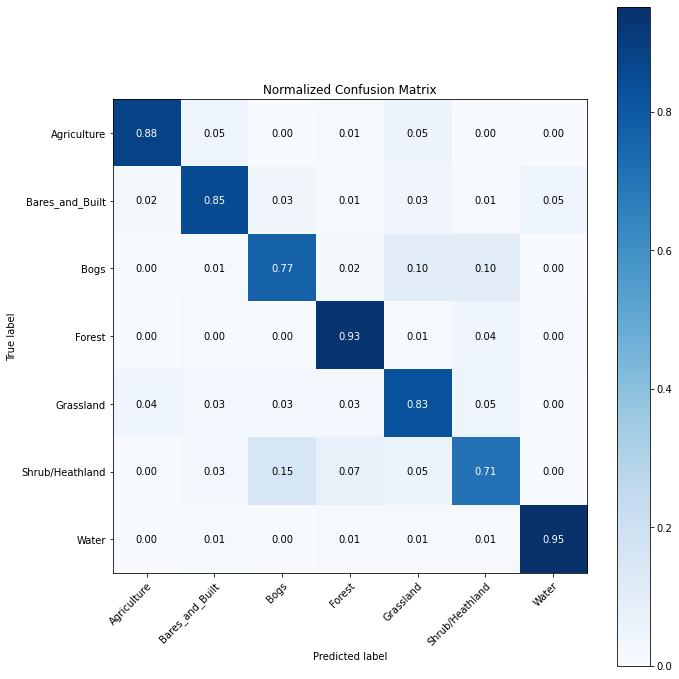

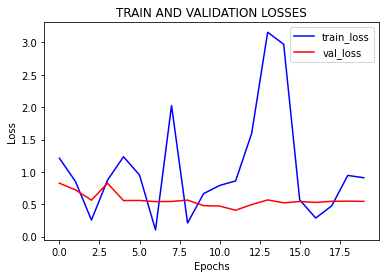

Accuracy:0.8705486184780387
Balanced Accuracy:0.8461622584583798
Recall:0.8705486184780387
Precision:0.8798550365927525
f1 score:0.8736222892307577
 
init features: 32, batch size: 16, learning rate: 0.001


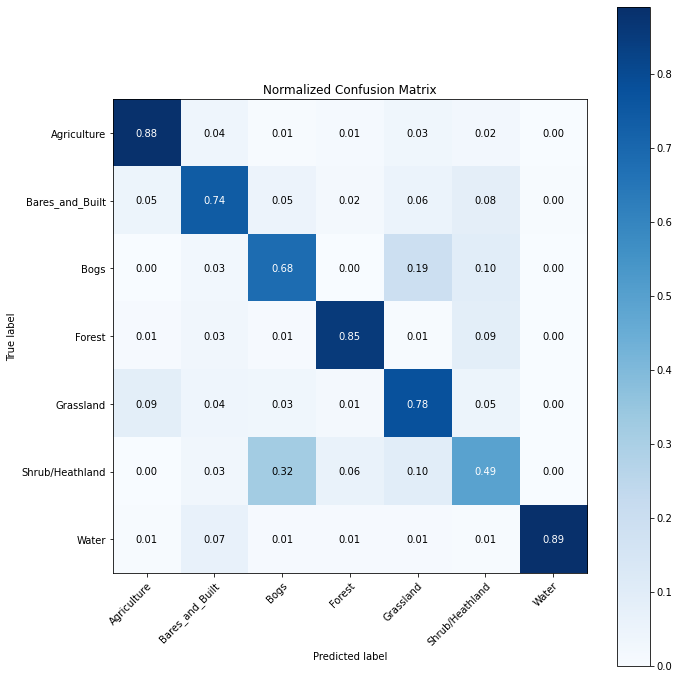

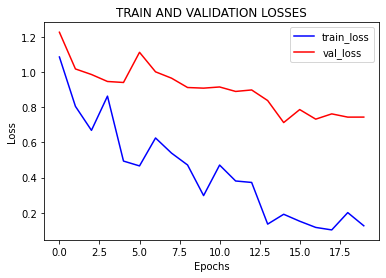

Accuracy:0.795683671918537
Balanced Accuracy:0.7596459710246268
Recall:0.795683671918537
Precision:0.8199436242463598
f1 score:0.8044979587322726
 
init features: 32, batch size: 16, learning rate: 0.001


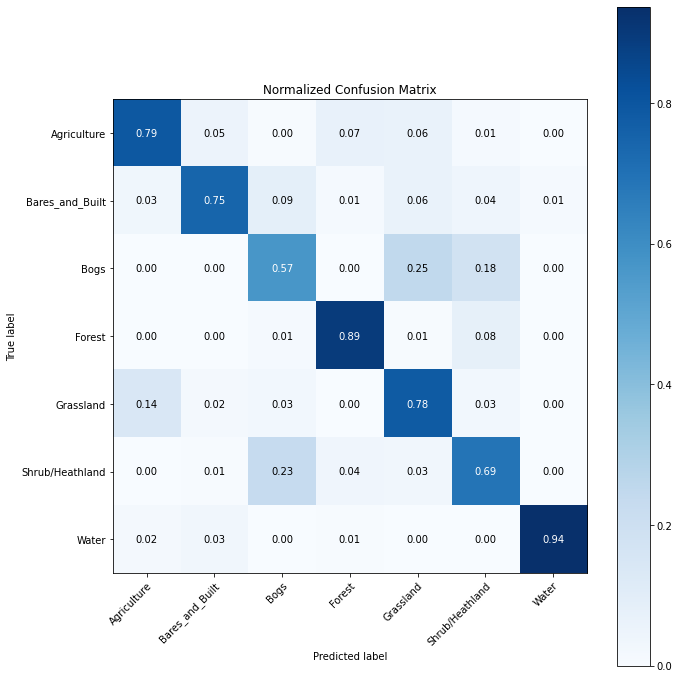

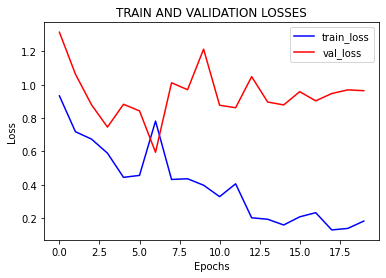

Accuracy:0.814374928834818
Balanced Accuracy:0.772855060502254
Recall:0.814374928834818
Precision:0.8303601899913529
f1 score:0.8203763324089868
percentage:0.3
The mean balanced accuracy is:0.7928877633284203
The mean accuracy is:0.8268690730771312
The mean precision is:0.8422002944503517
The mean recall is:0.8235281224174197
The mean f1 score is:0.8302482986552938
 
The std balanced accuracy is:0.03805477530018236
The std accuracy is:0.03181475324541596
The std precision is:0.02613559091302159
The std recall is:0.03181475324541596
The std f1 score is:0.02956241558192703
 
init features: 32, batch size: 16, learning rate: 0.001


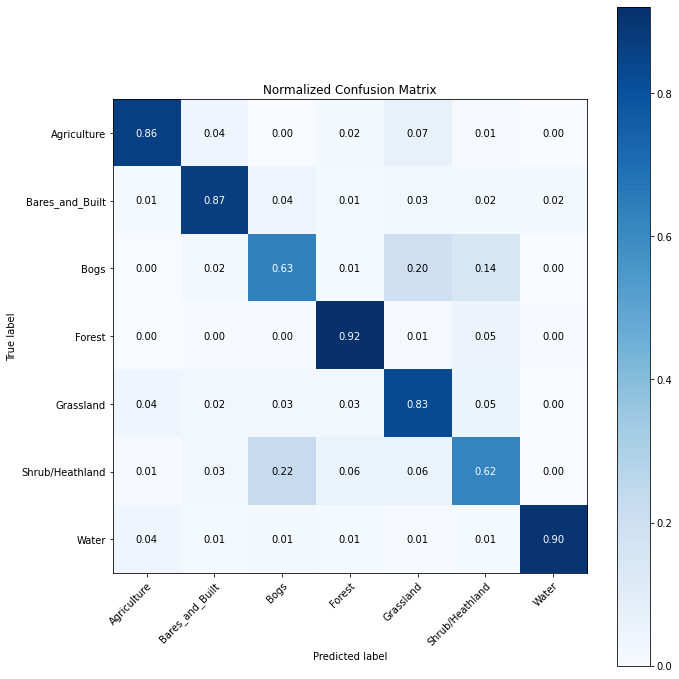

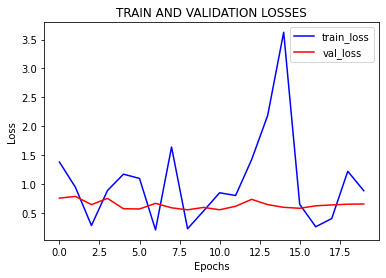

Accuracy:0.8497795598983932
Balanced Accuracy:0.8055382844265798
Recall:0.8497795598983932
Precision:0.8638600537483189
f1 score:0.855043155194179
 
init features: 32, batch size: 16, learning rate: 0.001


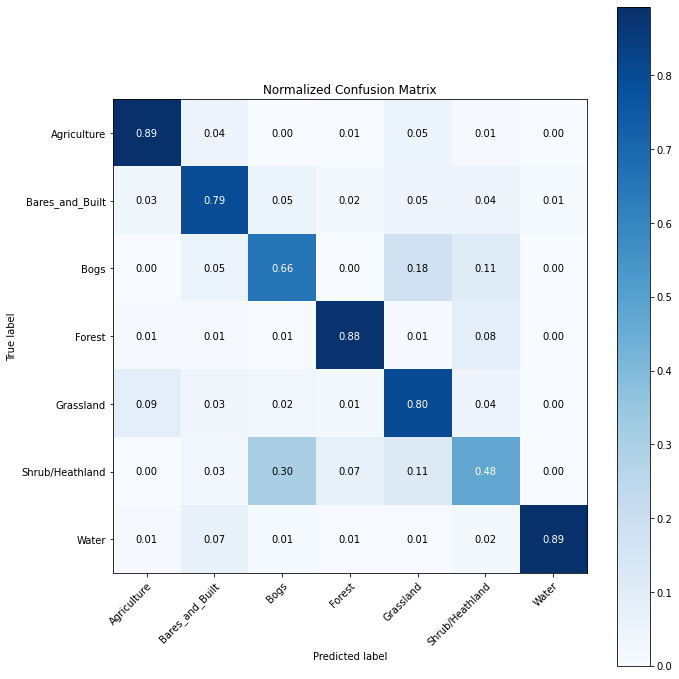

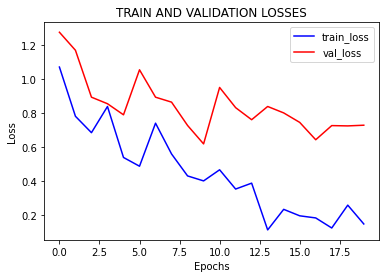

Accuracy:0.813506256649273
Balanced Accuracy:0.7693568527702472
Recall:0.813506256649273
Precision:0.8286014177771003
f1 score:0.8191511819867358
 
init features: 32, batch size: 16, learning rate: 0.001


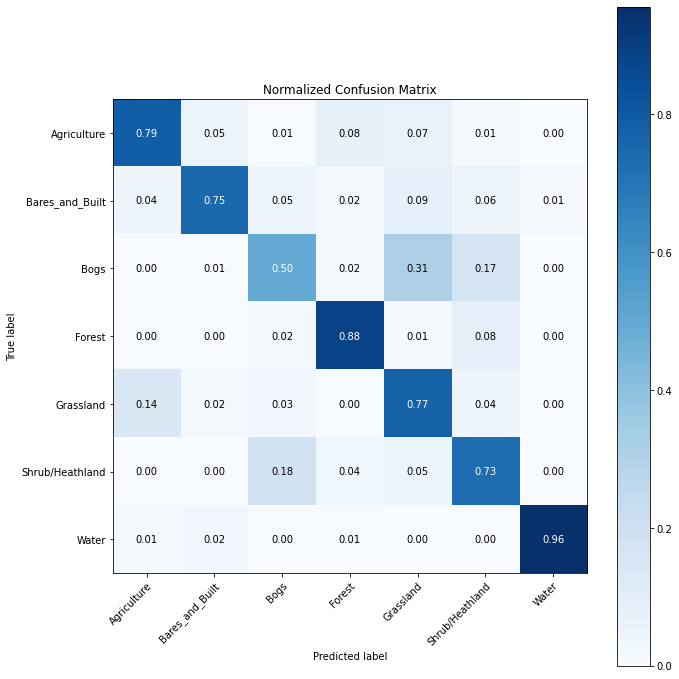

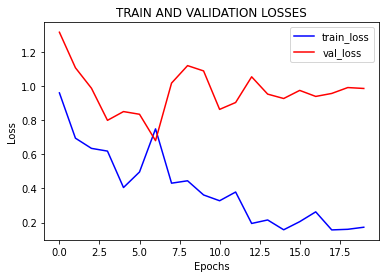

Accuracy:0.8082875686470294
Balanced Accuracy:0.7676928437375568
Recall:0.8082875686470294
Precision:0.8247043409684081
f1 score:0.8140552333737872
percentage:0.4
The mean balanced accuracy is:0.7808626603114611
The mean accuracy is:0.8238577950648985
The mean precision is:0.8415712897265365
The mean recall is:0.8235940569469153
The mean f1 score is:0.8300819436278818
 
The std balanced accuracy is:0.01746152056414683
The std accuracy is:0.018452860576406376
The std precision is:0.017611639022427523
The std recall is:0.018452860576406376
The std f1 score is:0.01823979826930411
 
init features: 32, batch size: 16, learning rate: 0.001


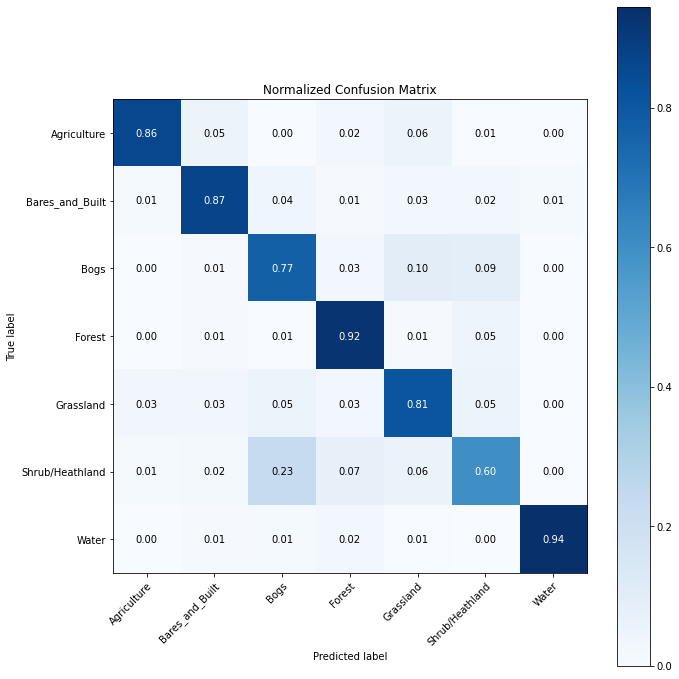

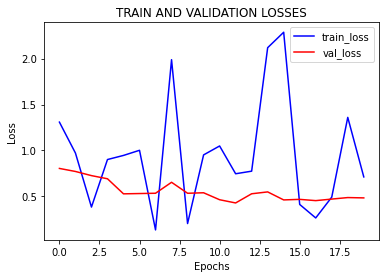

Accuracy:0.8493902617057101
Balanced Accuracy:0.8250002313225785
Recall:0.8493902617057101
Precision:0.8671276884630522
f1 score:0.8550611318532249
 
init features: 32, batch size: 16, learning rate: 0.001


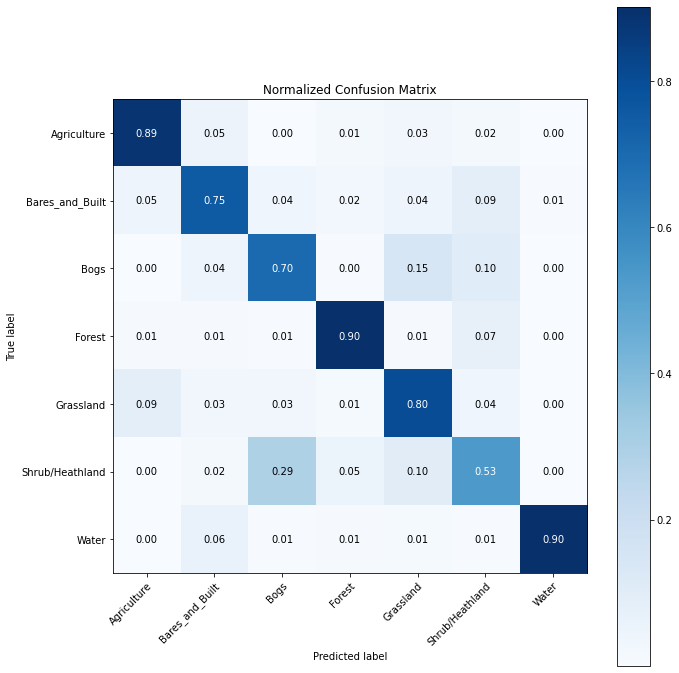

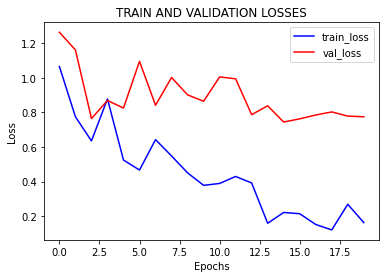

Accuracy:0.8215107148285121
Balanced Accuracy:0.781361756965552
Recall:0.8215107148285121
Precision:0.8375236647420851
f1 score:0.8275177959409958
 
init features: 32, batch size: 16, learning rate: 0.001


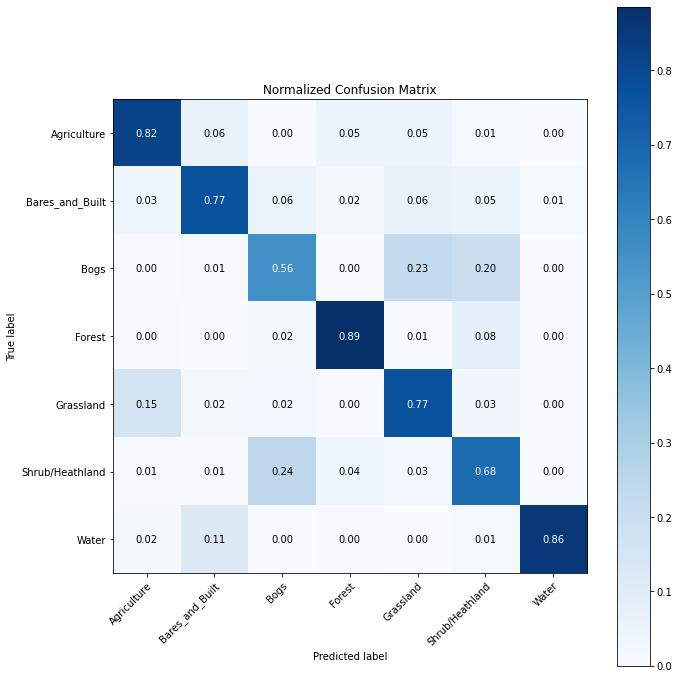

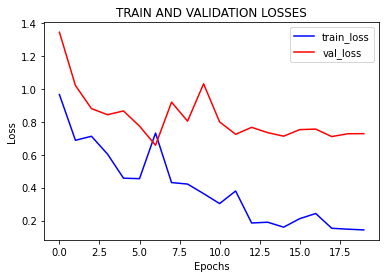

Accuracy:0.8087167494372476
Balanced Accuracy:0.7625581892456409
Recall:0.8087167494372476
Precision:0.8283075282527309
f1 score:0.8159270988736348
percentage:0.5
The mean balanced accuracy is:0.7896400591779238
The mean accuracy is:0.8265392419904899
The mean precision is:0.8420293459642175
The mean recall is:0.8240849211208445
The mean f1 score is:0.8305408433936713
 
The std balanced accuracy is:0.026155303736514975
The std accuracy is:0.01698132727688963
The std precision is:0.01656079785724577
The std recall is:0.01698132727688963
The std f1 score is:0.01641290870331053
 
init features: 32, batch size: 16, learning rate: 0.001


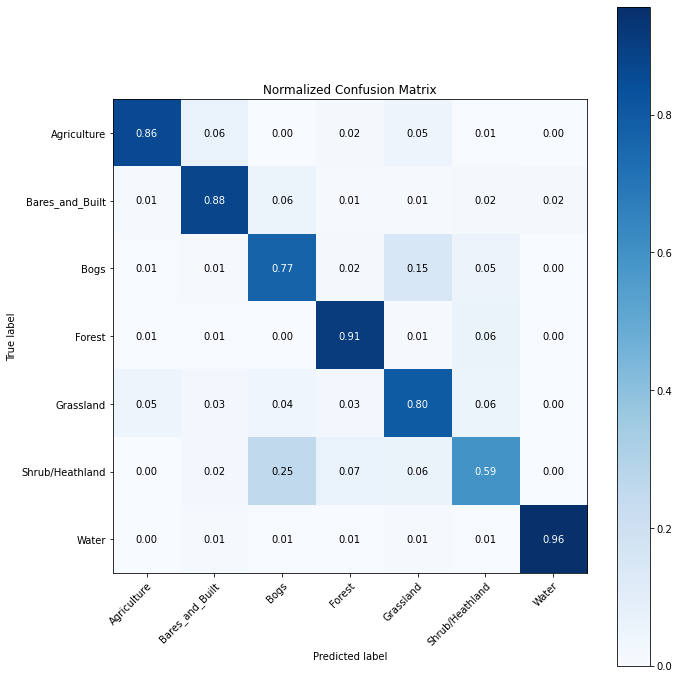

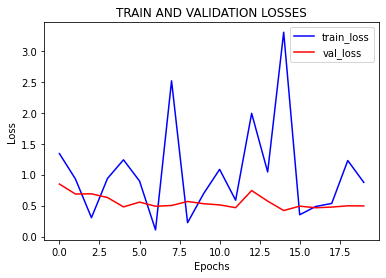

Accuracy:0.8450690517669271
Balanced Accuracy:0.823525849894126
Recall:0.8450690517669271
Precision:0.864643483703115
f1 score:0.8515415178432724
 
init features: 32, batch size: 16, learning rate: 0.001


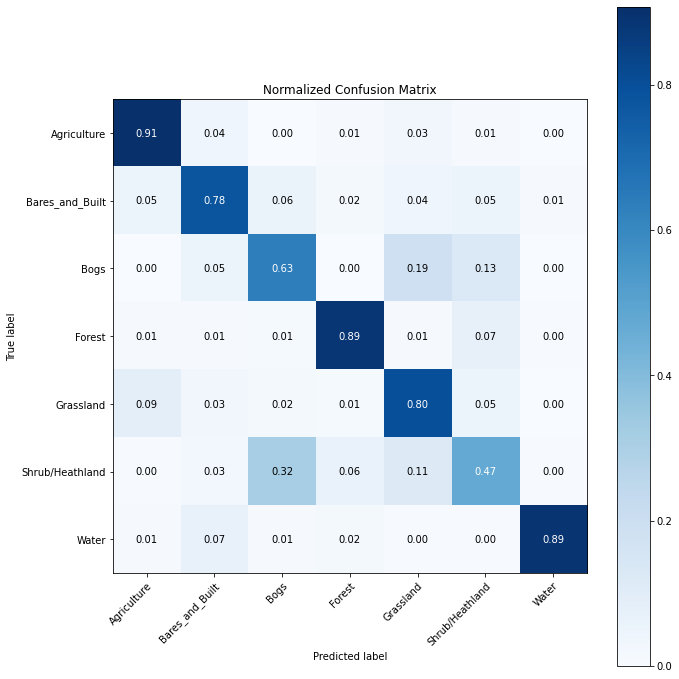

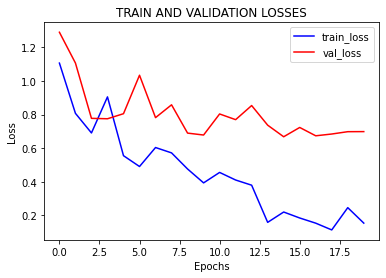

Accuracy:0.8150260904807741
Balanced Accuracy:0.7666543219999938
Recall:0.8150260904807741
Precision:0.8311978502868038
f1 score:0.8209922097305931
 
init features: 32, batch size: 16, learning rate: 0.001


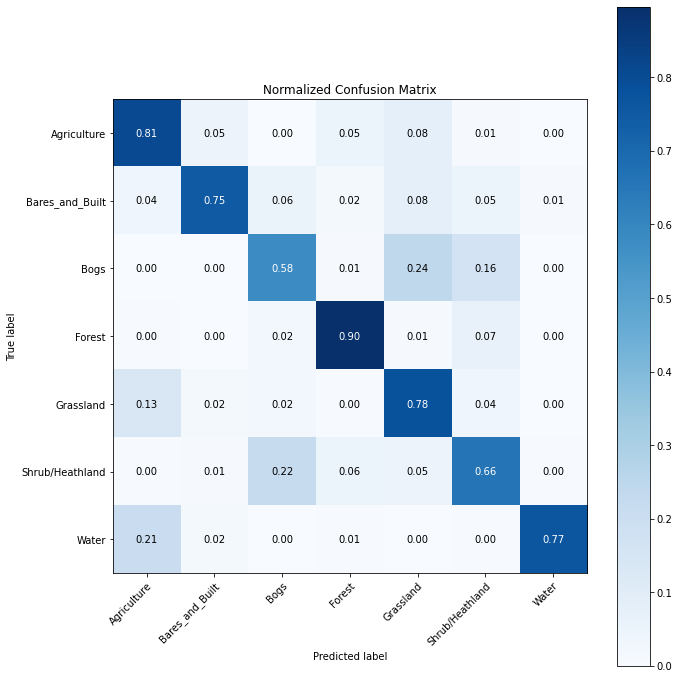

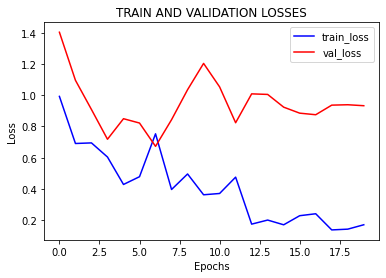

Accuracy:0.798968214345149
Balanced Accuracy:0.7480199354558285
Recall:0.798968214345149
Precision:0.8163886601138648
f1 score:0.804806096409701
percentage:0.6
The mean balanced accuracy is:0.7794000357833162
The mean accuracy is:0.8196877855309501
The mean precision is:0.8413694391171286
The mean recall is:0.8234567588937168
The mean f1 score is:0.8298607145271262
 
The std balanced accuracy is:0.03211568353806446
The std accuracy is:0.01910707291908648
The std precision is:0.020183740727587295
The std recall is:0.01910707291908648
The std f1 score is:0.01937767933351753
 
init features: 32, batch size: 16, learning rate: 0.001


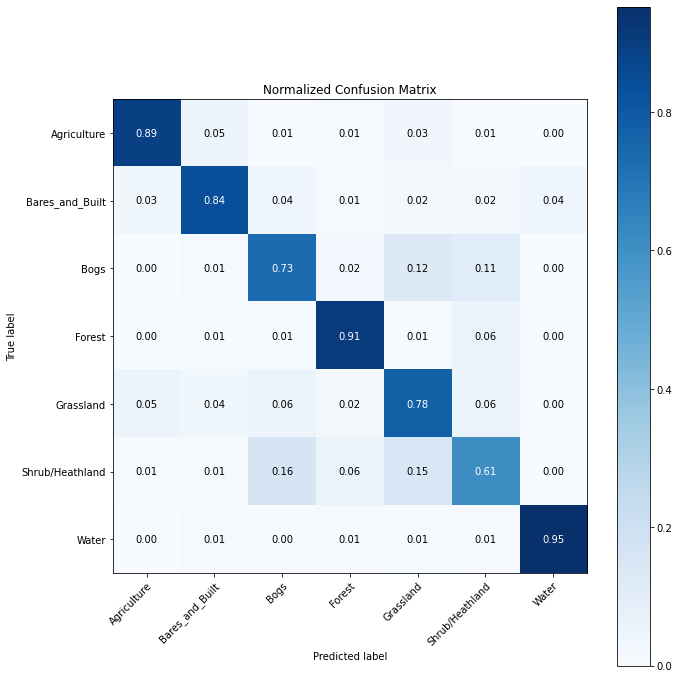

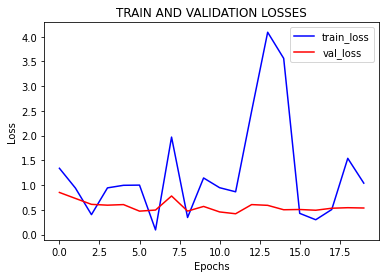

Accuracy:0.8457308586944885
Balanced Accuracy:0.8159638343931974
Recall:0.8457308586944885
Precision:0.8611985316155264
f1 score:0.8512011412973176
 
init features: 32, batch size: 16, learning rate: 0.001


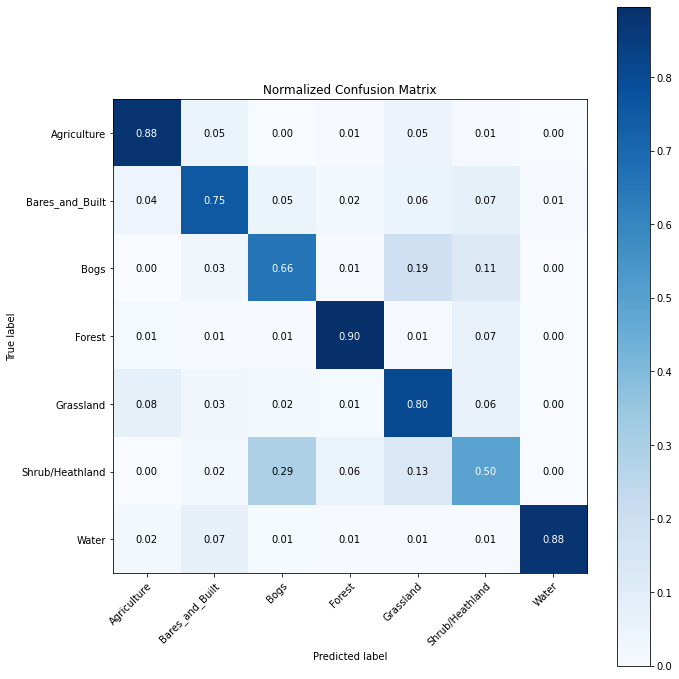

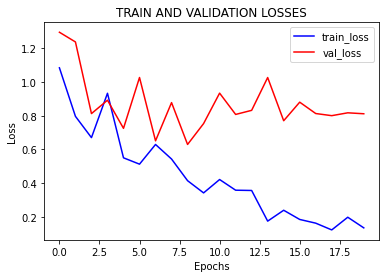

Accuracy:0.8147119914889306
Balanced Accuracy:0.766268878086983
Recall:0.8147119914889306
Precision:0.8288076086354845
f1 score:0.8202482307166127
 
init features: 32, batch size: 16, learning rate: 0.001


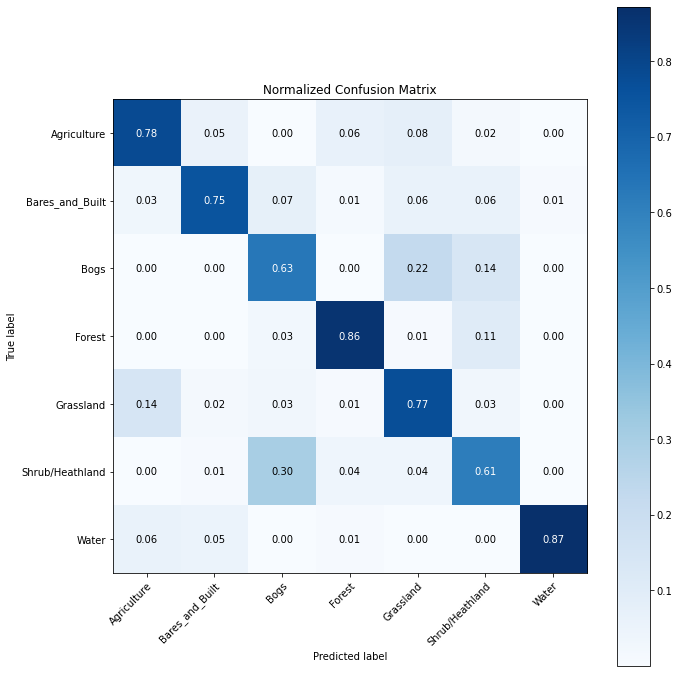

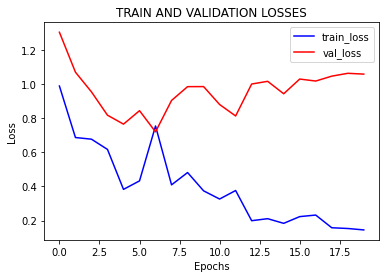

Accuracy:0.7921976684096662
Balanced Accuracy:0.7540834124810692
Recall:0.7921976684096662
Precision:0.8183980804040124
f1 score:0.8021592186337652
percentage:0.7
The mean balanced accuracy is:0.7787720416537499
The mean accuracy is:0.8175468395310284
The mean precision is:0.8407151017547801
The mean recall is:0.8227180189733807
The mean f1 score is:0.829195149821556
 
The std balanced accuracy is:0.026764945711243823
The std accuracy is:0.02194656978640151
The std precision is:0.018225162073383934
The std recall is:0.02194656978640151
The std f1 score is:0.020249568473010807


In [ ]:
percentages = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7]
mean_balanced_accuracy = []
mean_recall = []
mean_prec = []
mean_f1 = []
mean_accuracy=[]

std_balanced_accuracy = []
std_recall = []
std_prec = []
std_f1 = []
std_accuracy = []


for percentage in percentages:
      
      results_acc,results_bal_acc,results_prec,results_recall,results_f1,results_cm = cross_validate_dl_model(labels,classes,32,20,16,1e-3,X,y,folds=3,seed=42,augment=True,percentage=percentage)

      mean_balanced_accuracy.append(np.array(results_bal_acc).mean())
      mean_accuracy.append(np.array(results_acc).mean())
      mean_recall.append(np.array(results_recall).mean())
      mean_prec.append(np.array(results_prec).mean())
      mean_f1.append(np.array(results_f1).mean())

      std_balanced_accuracy.append(np.array(results_bal_acc).std())
      std_accuracy.append(np.array(results_acc).std())
      std_recall.append(np.array(results_recall).std())
      std_prec.append(np.array(results_prec).std())
      std_f1.append(np.array(results_f1).std())



      
      
      print(f'percentage:{percentage}')
      print(f'The mean balanced accuracy is:{np.array(results_bal_acc).mean()}')
      print(f'The mean accuracy is:{np.array(results_acc).mean()}')
      print(f'The mean precision is:{np.array(mean_prec).mean()}')
      print(f'The mean recall is:{np.array(mean_recall).mean()}')
      print(f'The mean f1 score is:{np.array(mean_f1).mean()}')
      print(' ')
      print(f'The std balanced accuracy is:{np.array(results_bal_acc).std()}')
      print(f'The std accuracy is:{np.array(results_acc).std()}')
      print(f'The std precision is:{np.array(results_prec).std()}')
      print(f'The std recall is:{np.array(results_recall).std()}')
      print(f'The std f1 score is:{np.array(results_f1).std()}')
    


In [ ]:
mean_prec

[0.8395648860429503,
 0.8367935300947495,
 0.849056478053552,
 0.843386283610155,
 0.8390552708312757,
 0.8443196271526228,
 0.8374099980345946,
 0.8361347402183411]

In [ ]:
mean_accuracy

[0.8205242291513196,
 0.8167088637317471,
 0.8300103237094808,
 0.8268690730771312,
 0.8238577950648985,
 0.8265392419904899,
 0.8196877855309501,
 0.8175468395310284]

In [ ]:
mean_balanced_accuracy

[0.7843008980424729,
 0.783368028857077,
 0.8018500544917483,
 0.7928877633284203,
 0.7808626603114611,
 0.7896400591779238,
 0.7794000357833162,
 0.7787720416537499]

In [ ]:
std_balanced_accuracy

[0.03117545011203372,
 0.032946975394123855,
 0.03090135255265561,
 0.03805477530018236,
 0.01746152056414683,
 0.026155303736514975,
 0.03211568353806446,
 0.026764945711243823]

#KFold

In [ ]:
mean_balanced_accuracy = []
mean_recall = []
mean_prec = []
mean_f1 = []
mean_cm = []
mean_accuracy=[]

In [ ]:
loops=3
init_features = 100
epochs = 38
init_lr = 1e-3
batch_size = 4

In [ ]:
for i in range(10,12):
    
    results_acc,results_bal_acc,results_prec,results_recall,results_f1,results_cm = cross_validate_dl_model(labels,classes,init_features,epochs,batch_size,init_lr,X,y,folds=3,seed=i,augment=True)
    mean_balanced_accuracy.extend(results_bal_acc)
    mean_recall.extend(results_recall)
    mean_prec.extend(results_prec)
    mean_f1.extend(results_f1)
    mean_cm.extend(results_cm)
    mean_accuracy.extend(results_acc)

In [ ]:
print(f'The mean balanced accuracy is:{np.array(mean_balanced_accuracy).mean()}')
print(f'The mean precision is:{np.array(mean_prec).mean()}')
print(f'The mean recall is:{np.array(mean_recall).mean()}')
print(f'The mean f1 score is:{np.array(mean_f1).mean()}')

# the final confusion matrix
final_sum_cm = np.zeros(mean_cm[0].shape)
for matrix in mean_cm:
   final_sum_cm +=matrix
final_mean_cm = final_sum_cm/len(mean_cm)

print('FINAL MEAN CONFUSION MATRIX')
CNN_Train_Validate.plot_cm(final_mean_cm,classes)

In [ ]:
mean_balanced_accuracy_df = pd.DataFrame(mean_balanced_accuracy,columns=['mean_balanced_accuracy'])
mean_balanced_accuracy_df.describe()

,mean_balanced_accuracy
count,15.000000
mean,0.803539
std,0.020789
min,0.773553
25%,0.789953
50%,0.795040
75%,0.814652
max,0.858730


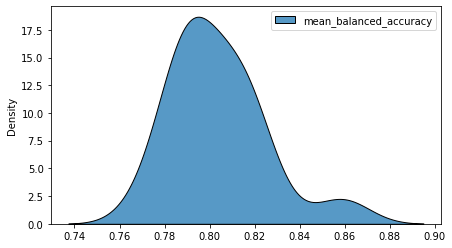

In [ ]:
plt.figure(figsize=(7,4))
sns.kdeplot(data=mean_balanced_accuracy_df, multiple="stack")
plt.show()

In [ ]:
mean_balanced_accuracy_df

,mean_balanced_accuracy
0,0.773553
1,0.807205
2,0.794522
3,0.790451
4,0.813571
5,0.795040
6,0.791122
7,0.815734
8,0.808524
9,0.858730


#Generate Map

In [ ]:
# create a test model
model_loaded = CNN_Train_Validate.UNet(in_channels=13,out_channels=7,init_features=100).cuda()

In [ ]:
model_loaded.load_state_dict(torch.load('/content/drive/MyDrive/Space_Intelligence/Project_Scotland/Scotland_Segmentation_Sparse_Labels/data/Best.net'));
model_loaded.eval();

In [ ]:
raster_image = '/content/drive/MyDrive/Space_Intelligence/Project_Scotland/data/raster_file/big.tif'
raster_subimage = '/content/drive/MyDrive/Space_Intelligence/Project_Scotland/Scotland_Segmentation_Sparse_Labels/Maps/Scotland_Subraster.tif'
raster_subimage_classifier = '/content/drive/MyDrive/Space_Intelligence/Project_Scotland/Scotland_Segmentation_Sparse_Labels/Maps/0.tif'
bands = 13
windows_height = 1024
windows_width = 1024
origin_x = 2500
origin_y = 2500

In [ ]:
CNN_Train_Validate.create_map(model,raster_image,raster_subimage,raster_subimage_classifier,
           windows_height,windows_width,origin_x,origin_y,bands,gpu=True)

In [ ]:
torch.cuda.empty_cache()